In [11]:
%pylab inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os
import glob
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import fitsne
from sklearn.model_selection import cross_val_score

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from skimage.color import rgb2gray

from pywsi.io import WSIReader
from pywsi.io.operations import read_as_rgb

from pywsi.segmentation import poisson_deconvolve, perform_binary_cut, max_clustering
from pywsi.segmentation import collapse_labels, collapse_small_area, laplace_of_gaussian
from pywsi.segmentation import gmm_thresholding, label_nuclei, extract_features, summarize_region_properties

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization
from pywsi.normalization import VahadaneNormalization
from pywsi.normalization import XuNormalization

from sklearn.decomposition import PCA, FastICA
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import umap
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from tpot import TPOTClassifier
import pickle
from multiprocessing import Pool

scaler = StandardScaler()

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/'
tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/tumor_patches_test/level_0/'

np.random.seed(42)
list_of_tumor_files = list(glob.glob('{}*.png'.format(tumor_patches_dir)))
list_of_normal_files = list(glob.glob('{}*.png'.format(normal_patches_dir)))

#list_of_tumor_files = list(np.random.choice(list_of_tumor_files, 20000))
#list_of_normal_files = list(np.random.choice(list_of_normal_files, 20000))



In [3]:
def draw_nuclei(patch, local_max_search_radius=3, min_radius=5, max_radius=15, min_nucleus_area=100):
    patch = read_as_rgb(patch)
    label_nuclei(patch,
                 local_max_search_radius=local_max_search_radius, 
                 min_radius=min_radius,
                 max_radius=max_radius, 
                 min_nucleus_area=min_nucleus_area)
    

In [4]:
interact(draw_nuclei, patch=list_of_tumor_files+list_of_normal_files)


interactive(children=(Dropdown(description='patch', options=('/Z/personal-folders/interns/saket/histopath_data…

<function __main__.draw_nuclei(patch, local_max_search_radius=3, min_radius=5, max_radius=15, min_nucleus_area=100)>

In [5]:
patch = read_as_rgb(list_of_tumor_files[0])

/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid alia

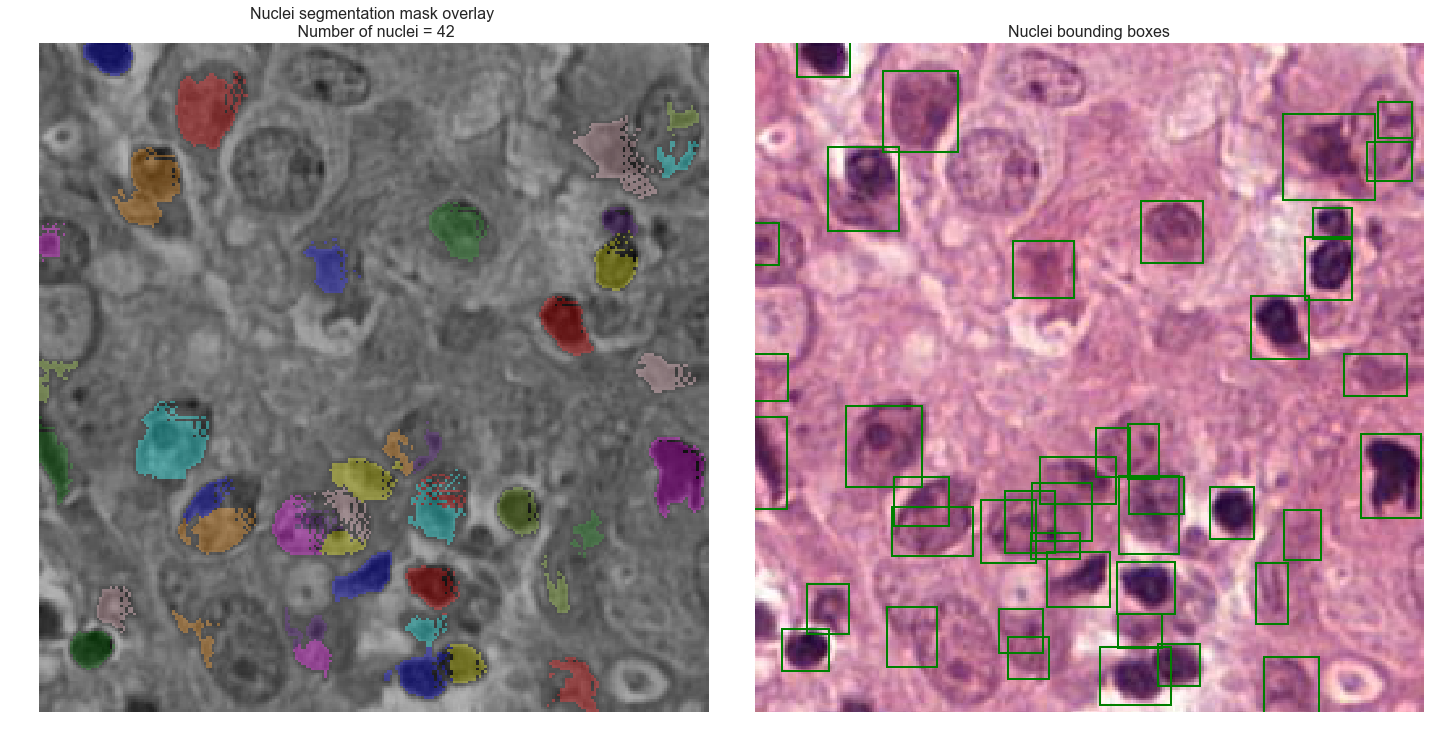

In [6]:
region_properties, fg_mask = label_nuclei(patch)

In [ ]:
features_df = []
labels = []
def process_sample(sample):
    patch = read_as_rgb(sample)
    region_properties, _ = label_nuclei(patch, draw=False) 
    summary = summarize_region_properties(region_properties, 
                                          patch)
    return summary
#for sample in tqdm_notebook(list_of_normal_files):

with tqdm_notebook(total=len(list_of_tumor_files)) as pbar:
    with Pool(processes=16) as p:
        for i, summary in enumerate(p.imap_unordered(process_sample, list_of_tumor_files)):
            pbar.update()
            if summary is None:
                print('Nothing found for {}'.format(sample))
                continue
            else:
                labels.append('tumor')
    features_df.append(summary)
    
pickle.dump(features_df, open('normal.pickle', 'wb'))

In [ ]:
with tqdm_notebook(total=len(list_of_normal_files)) as pbar:
    with Pool(processes=16) as p:
        for i, summary in enumerate(p.imap_unordered(process_sample, list_of_tumor_files)):
            pbar.update()
            if summary is None:
                print('Nothing found for {}'.format(sample))
                continue
            else:
                labels.append('normal')
    features_df.append(summary)
pickle.dump(features_df, open('tumor.pickle', 'wb'))

In [ ]:
#tfile = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/tumor_048_33856_186816_256.png'
y = np.array([1  if label=='normal' else 0 for label in labels])

In [ ]:
f = pd.DataFrame(features_df)
X = f.values

In [ ]:
X_scaled = scaler.fit(X).transform(X)

In [ ]:
X_scaled.shape

# PCA

We start of with doing PCA/tSNE on the features.


# UMAP

In [ ]:

embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 10))

for color, i, target_name in zip(colors, [0, 1], label_matrix):
    plt.scatter(embedding[y == i, 0], embedding[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
fig.tight_layout()
plt.title('UMAP')

In [ ]:
Y = fitsne.FItSNE(X_scaled.copy(order='C'))# max_iter=500)

In [ ]:
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2))
std_clf.fit(X)



In [ ]:
colors = ['navy', 'darkorange']
lw = 0.2
label_matrix = ['normal', 'tumor']

fig = plt.figure(figsize=(10, 10))
for color, i, target_name in zip(colors, [0, 1], label_matrix):
    plt.scatter(Y[y == i, 0], Y[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

fig.tight_layout()
plt.title('FIt-SNE')

# Random Forest

In [ ]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=40)
print(clf.feature_importances_)

# LASSO

In [ ]:
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)

In [ ]:
y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)

In [ ]:
r2_score_lasso

In [ ]:
alpha = 0.001
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
r2_score_enet

In [ ]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)


In [ ]:
print(pipeline_optimizer.score(X_test, y_test))
